# Time series analysis

## Introduction 

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series.

## The data

We are using Superstore sales data that can be downloaded from [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls).

In [20]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

#set plotting defaults: These settings apply globally, affecting all subsequent plots unless overridden locally.
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [21]:
#set working directory
import os
os.chdir('/Users/jancg/Library/CloudStorage/OneDrive-StellenboschUniversity/3_LE/3_Courses/AE_772_892')
df = pd.read_excel("data/raw/Sample - Superstore.xls")
print(df.columns)


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


OK, the lets fix the column names so that we can work with them more easily.

In [22]:
#set column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

Now lets subset the data to only the furniture sales.

In [23]:
df_furn = df.loc[df['category'] == 'Furniture']

Lets look at the data, we have a good 4-year furniture sales data.

In [24]:
df_furn['order_date'].min(), df_furn['order_date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

Lets remove the columns we do not need, check missing values, aggregate sales by date and so on.

In [25]:
df_furn = df_furn[['order_date', 'sales']]
df_furn = df_furn.sort_values('order_date')
print(df_furn)

     order_date     sales
7474 2014-01-06  2573.820
7660 2014-01-07    76.728
866  2014-01-10    51.940
716  2014-01-11     9.940
2978 2014-01-13   545.940
...         ...       ...
7636 2017-12-29   258.750
7632 2017-12-29  1207.840
5131 2017-12-29   101.120
7635 2017-12-29   300.980
906  2017-12-30   323.136

[2121 rows x 2 columns]


Lets check for missing values, if so, we wil have to deal with them.

In [26]:
df_furn.isnull().sum()

order_date    0
sales         0
dtype: int64

When working with time series data, one typically index the data by the date variable and check if the date variable is of the correct type.

In [27]:
df_furn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2121 entries, 7474 to 906
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_date  2121 non-null   datetime64[ns]
 1   sales       2121 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 49.7 KB


Great, it is in the correct format - lets proceed to index the dataframe with the date variable.

In [28]:
df_furn = df_furn.set_index('order_date')
df_furn.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='order_date', length=2121, freq=None)

Our current date and time data is a bit hard to handle, so we'll use the average daily sales for each month instead. We'll mark these averages with the first day of each month as the timestamp.

In [29]:
df_fm = df_furn['sales'].resample('MS').mean()

The code line `df_fm = df_furn['sales'].resample('MS').mean()` performs the following operations on a pandas DataFrame `df_furn`:

- `df_furn['sales']`: Selects the 'sales' column from the DataFrame.
- `.resample('MS')`: Resamples the time series data based on the start of each month. The 'MS' stands for 'Month Start'.
- `.mean()`: Calculates the average of all 'sales' values falling within each monthly period.

The result is stored in a new DataFrame `df_fm`, which contains the average daily sales values for each month, indexed by the start of each month.

Lets have a look at the data for 2017

In [30]:
df_fm['2017':]

order_date
2017-01-01    248.501333
2017-02-01    264.089900
2017-03-01    286.669600
2017-04-01    206.044502
2017-05-01    319.953928
2017-06-01    372.717386
2017-07-01    227.173500
2017-08-01    395.945487
2017-09-01    349.737422
2017-10-01    308.226313
2017-11-01    374.310253
2017-12-01    296.296857
Freq: MS, Name: sales, dtype: float64

Lets plot it out

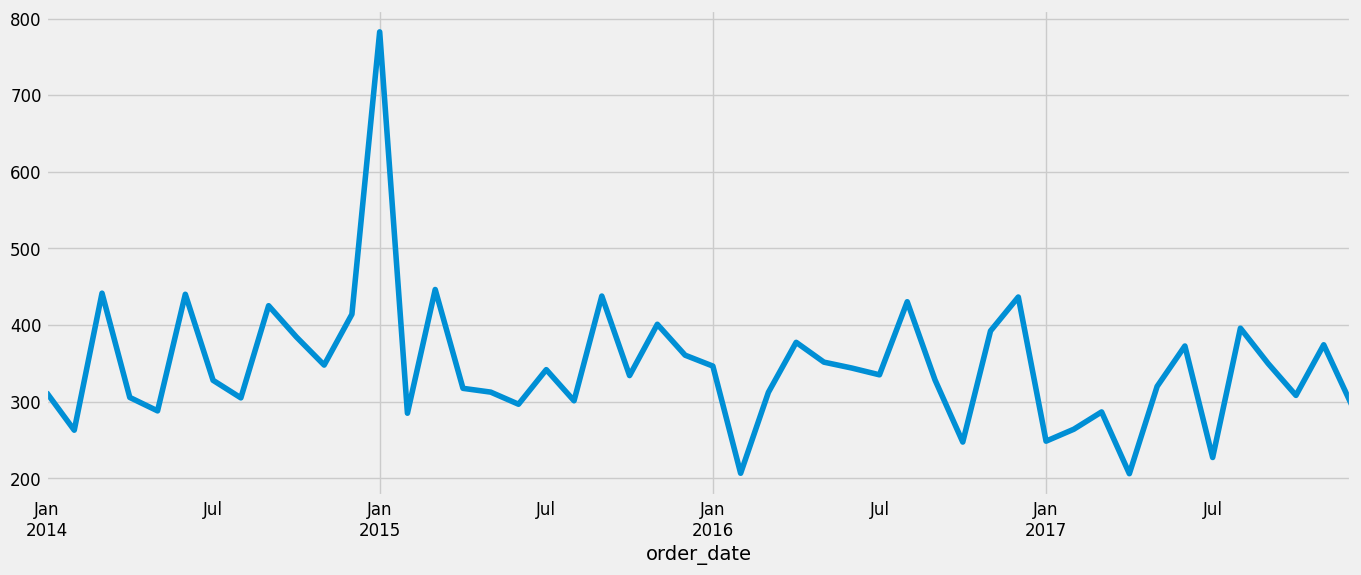

In [31]:
df_fm.plot(figsize=(15, 6))
plt.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise. The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

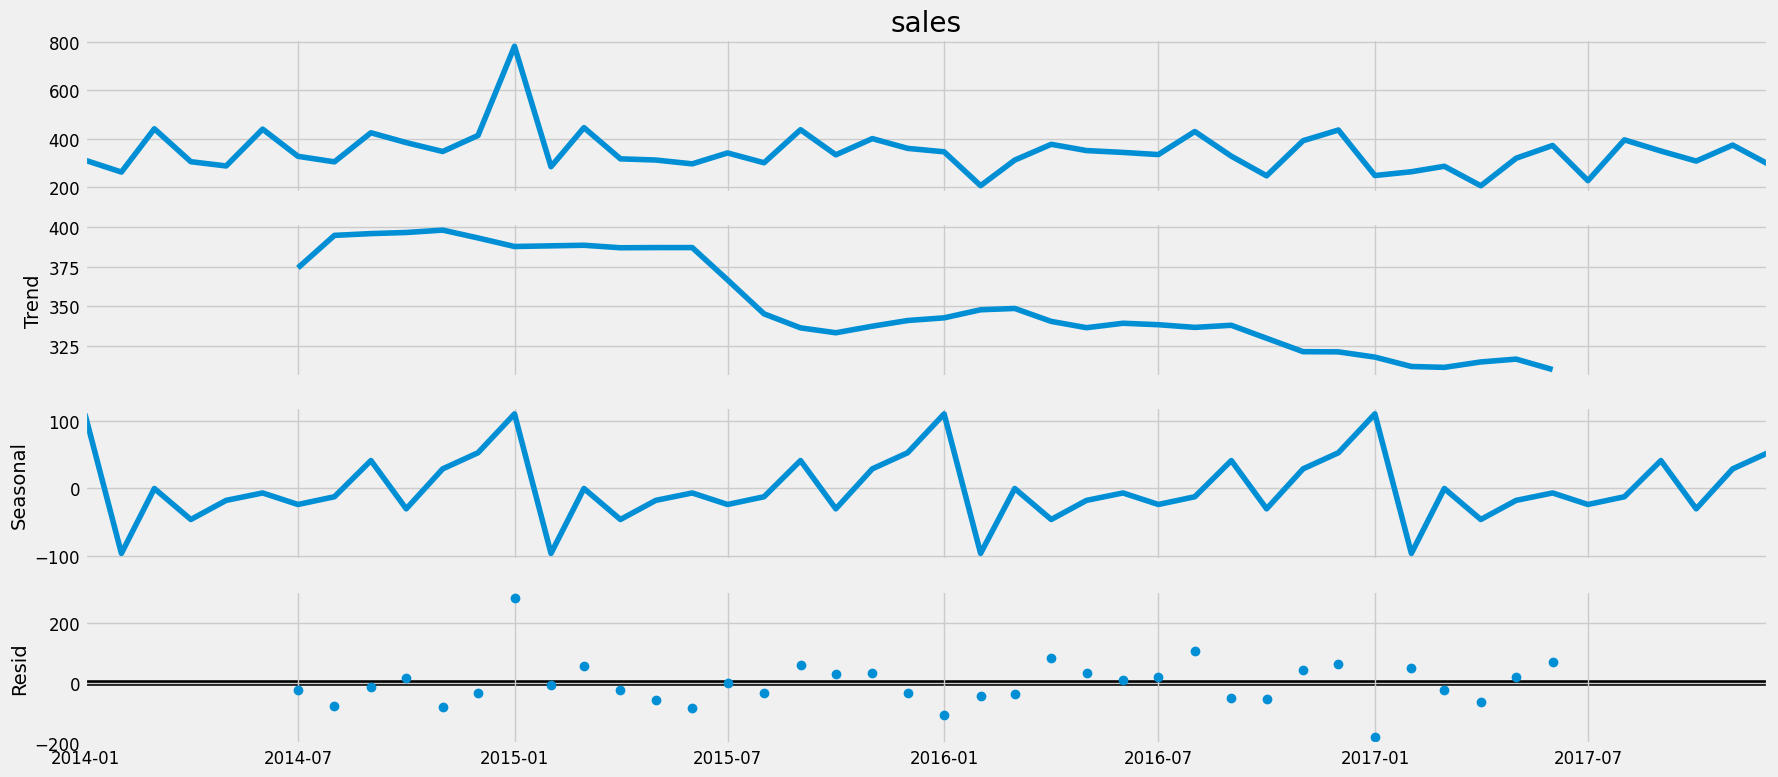

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_fm, model='additive')
fig = decomposition.plot()
plt.show()

The function `sm.tsa.seasonal_decompose` is a part of the `statsmodels` library in Python and is employed for the decomposition of a time series. The function breaks down a time series into three distinct components: trend, seasonality, and residual (noise).

Here is what each argument in the function signifies:

- `ydf_fm`: This is the time series data that you want to decompose. It is usually passed as a Pandas Series object.
- `model`: This is the model type for the decomposition. When set to `'additive'`, the function assumes that the time series is an additive model of the form \( y_t = \text{Trend}_t + \text{Seasonal}_t + \text{Residual}_t \).

The output is an object that contains the trend, seasonal, and residual components, which can be accessed as attributes (`.trend`, `.seasonal`, `.resid`).

In summary, `sm.tsa.seasonal_decompose(y, model='additive')` performs an additive decomposition of the time series `y` into its constitutive components.

Interpreting the results of a time series decomposition involves examining the trend, seasonal, and residual components to glean insights about the underlying structure of the data. Below are the key aspects to consider for each component:

### Trend
The trend component reveals the underlying pattern in the series over a long time span. If the trend is upwards, it may indicate growth; if downwards, it could signify decline. A flat trend suggests stability. Understanding the trend can help in making long-term forecasts.

### Seasonal
The seasonal component captures the repeating patterns or cycles in the data. Seasonality can occur on various scales such as daily, monthly, or annually. Understanding this component is crucial for making short-term predictions and planning for seasonal variations in demand, supply, etc.

### Residual
The residual component contains the random variations in the time series that are not accounted for by the trend and seasonal components. Analyzing the residual can be useful for diagnosing the fit of the model. Ideally, the residuals should approximate white noise (i.e., be normally distributed with a mean of zero), indicating that the model has successfully captured the underlying structure.



## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that captures a suite of different standard temporal structures in time series data. The ARIMA model is defined by three parameters: \( (p, d, q) \):

- \( p \): The number of lag observations included in the model, also known as the lag order.
- \( d \): The number of times that the raw observations are differenced, also known as the degree of differencing.
- \( q \): The size of the moving average window, also known as the order of the moving average.

In addition to these, Seasonal ARIMA (SARIMA) includes seasonal terms and is defined by \( (P, D, Q, S) \):

- \( P \): The number of seasonal autoregressive (SAR) terms.
- \( D \): The number of seasonal differences.
- \( Q \): The number of seasonal moving average (SMA) terms.
- \( S \): The number of time steps per season (e.g., 12 for monthly data with an annual cycle).

The ARIMA model aims to predict future data points by understanding the underlying trends and patterns in the time series data. The combination of these parameters makes ARIMA highly flexible, able to model a wide range of time series data.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

The Akaike Information Criterion (AIC) is a statistical measure used for model selection among a finite set of models. The AIC provides a trade-off between the goodness-of-fit of the model and the complexity of the model. It is defined as:

$
    \text{AIC} = 2k - 2\ln(L)
$

where \( k \) is the number of estimated parameters in the model, and \( L \) is the maximum value of the likelihood function for the model. Lower AIC values indicate a better fit of the model to the data, given the number of parameters.



In [34]:
# Initialize a list to store the results
results_list = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_fm,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            # Save results as a dictionary and append to the list
            results_list.append({
                'param': param, 
                'param_seasonal': param_seasonal, 
                'aic': results.aic,
                'bic': results.bic,
                'mse': ((results.resid)**2).mean()
            })
        except:
            continue
results_list[0]

{'param': (0, 0, 0),
 'param_seasonal': (0, 0, 0, 12),
 'aic': 688.3112416991725,
 'bic': 690.1613893008825,
 'mse': 127953.94440993684}

In [35]:
# Normalize the metrics
min_aic = min(x['aic'] for x in results_list)
min_bic = min(x['bic'] for x in results_list)
min_mse = min(x['mse'] for x in results_list)

for result in results_list:
    result['norm_aic'] = result['aic'] / min_aic
    result['norm_bic'] = result['bic'] / min_bic
    result['norm_mse'] = result['mse'] / min_mse

# Calculate composite scores
for result in results_list:
    result['composite_score'] = result['norm_aic'] + result['norm_bic'] + result['norm_mse']

# Find the entry with the lowest composite score
best_result = min(results_list, key=lambda x: x['composite_score'])
best_result

{'param': (0, 1, 1),
 'param_seasonal': (0, 1, 1, 12),
 'aic': 251.2470775508363,
 'bic': 254.38064486400657,
 'mse': 16805.206200988217,
 'norm_aic': 1.0,
 'norm_bic': 1.0,
 'norm_mse': 1.6137561846641517,
 'composite_score': 3.613756184664152}

Lets select the iteration with the lowest composite score.

In [36]:
# Extract the best parameters
best_order = best_result['param']
best_seasonal_order = best_result['param_seasonal']

# Fit the model with the best parameters
mod = sm.tsa.statespace.SARIMAX(df_fm,
                                order=best_order,
                                seasonal_order=best_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

# Print summary table
print(results.summary().tables[1])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64822D+00    |proj g|=  7.99254D-02

At iterate    5    f=  2.60742D+00    |proj g|=  1.93071D-03

At iterate   10    f=  2.60247D+00    |proj g|=  5.82957D-02

At iterate   15    f=  2.55673D+00    |proj g|=  4.24050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     28      1     0     0   3.789D-06   2.555D+00
  F =   2.5546570578212116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

 This problem is unconstrained.


### Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

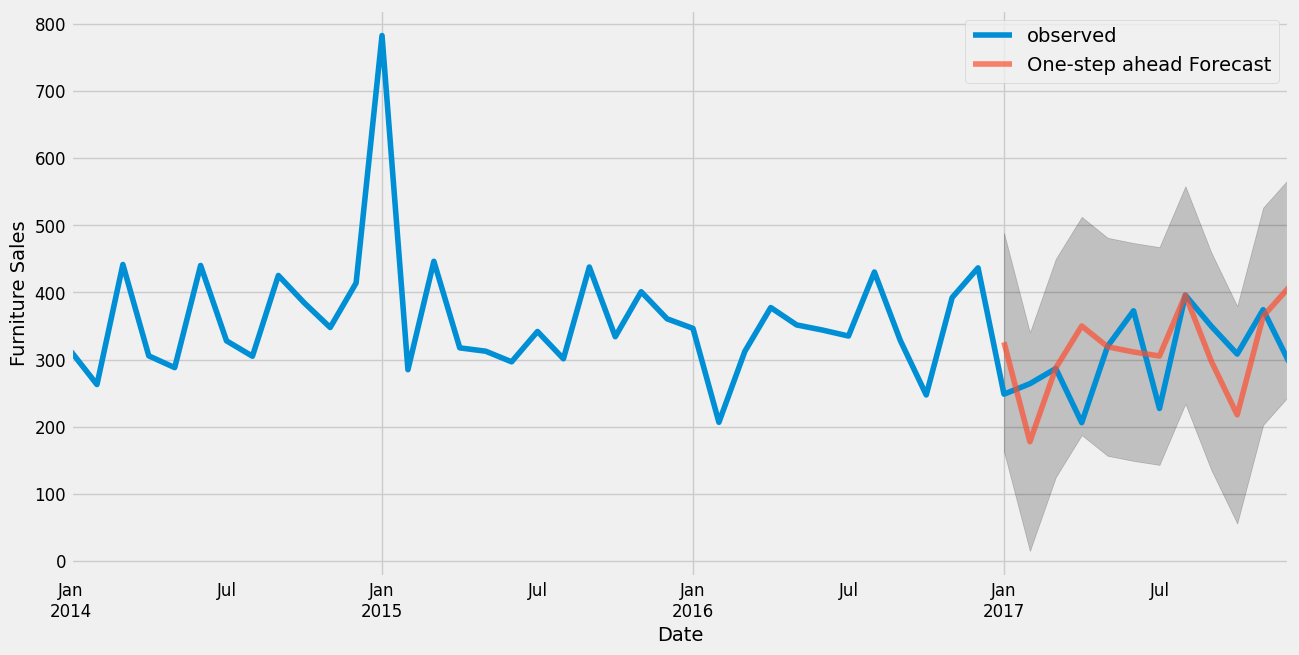

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_fm['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.

In [38]:
df_fm_forecasted = pred.predicted_mean
df_fm_truth = df_fm['2017-01-01':]
mse = ((df_fm_forecasted - df_fm_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5626.29


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

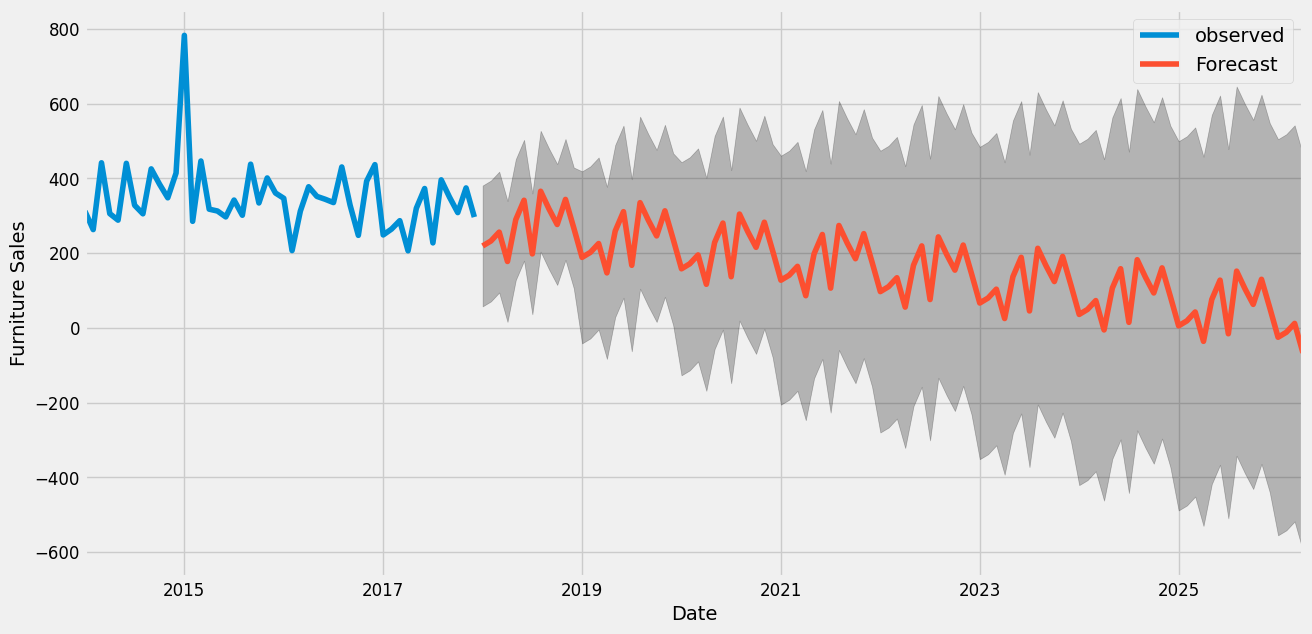

In [40]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_fm.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Tutorial 8: Time series analysis

- Import the Asian Development Bank data  `Procurement by Nationality (2013  2023) as of August 2023.csv` and do a one year forecast `ADB-FINANCED AMOUNT 
`